In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import os, sys, glob

In [3]:
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import matplotlib.ticker as ticker

In [4]:
from datetime import datetime

In [5]:
DATA_DIR = "../csse_covid_19_data/csse_covid_19_daily_reports"

In [6]:
# sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="whitegrid")
# sns.set(font_scale = 2)
# sns.set_style("whitegrid", {'grid.linestyle': ':'})

## Data loading

In [7]:
csv_files = glob.glob(DATA_DIR + "/*.csv")

In [8]:
def extract_date(file_name):
    date_str = os.path.basename(file_name)[:-4]
#     print(date_str)
    
#     date = datetime.strptime(match.group(), '%Y-%m-%d').date()
    date = datetime.strptime(date_str, '%m-%d-%Y').date()
#     print(date)
    
    return date

In [9]:
world_df = None

for csv_file in csv_files:
    
    df = pd.read_csv(csv_file)
    date = extract_date(csv_file)
    df['Date'] = date
    
    if world_df is None:
        world_df = df
    else:
        world_df = pd.concat((world_df, df), ignore_index=True)
    
#     break

### Setup individual country

In [10]:
# Uncomment in case you want to check the list of countries with available data

world_df['Country/Region'].unique()

array(['Mainland China', 'Others', 'South Korea', 'Japan', 'Singapore',
       'Hong Kong', 'Thailand', 'Taiwan', 'Malaysia', 'Germany',
       'Vietnam', 'France', 'Macau', 'UK', 'United Arab Emirates',
       'Australia', 'Canada', 'Iran', 'India', 'Italy', 'Philippines',
       'Russia', 'Spain', 'US', 'Belgium', 'Cambodia', 'Egypt', 'Finland',
       'Nepal', 'Sri Lanka', 'Sweden', 'Kuwait', 'Bahrain', 'Switzerland',
       'Iraq', 'Norway', 'Croatia', 'Greece', 'Israel', 'Oman', 'Austria',
       'Romania', 'Lebanon', 'Pakistan', ' Azerbaijan', 'Afghanistan',
       'Algeria', 'Belarus', 'Brazil', 'Denmark', 'Estonia', 'Georgia',
       'Iceland', 'Lithuania', 'Mexico', 'Netherlands', 'New Zealand',
       'Nigeria', 'North Ireland', 'North Macedonia', 'San Marino',
       'Ivory Coast', 'Czech Republic', 'Portugal', 'Palestine',
       'Ireland', 'Indonesia', 'Qatar', 'Poland', 'Slovenia', 'Ecuador',
       'Saudi Arabia', 'Argentina', 'Azerbaijan', 'Costa Rica', 'Hungary',
     

In [11]:
country_name = "Italy"
ESTIMATED_IC_CAPACITY = 5000

# country_name = "Sweden"
# ESTIMATED_IC_CAPACITY = 1000

In [12]:
# Get data for a single country, sorted by date

country_df = world_df[world_df['Country/Region'] == country_name].sort_values(by='Date')

# Estimate a reasonable value for Y tick given the maximum number of cases
Y_GRID_TICK = 10**int(np.log10(country_df['Confirmed'].max()))/2

In [13]:
# Uncomment to check data for a specific day

country_df[country_df['Date'] == datetime.strptime("03-03-2020", '%m-%d-%Y').date()]

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Date,Latitude,Longitude
3937,NaN,Italy,2020-03-03T20:03:06,2502.0,79.0,160.0,2020-03-03,43.0,12.0


In [14]:
# Check latest data

country_df.tail()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Date,Latitude,Longitude
1885,NaN,Italy,2020-03-06T17:33:03,4636.0,197.0,523.0,2020-03-06,43.0,12.0
1317,NaN,Italy,2020-03-07T17:33:03,5883.0,233.0,589.0,2020-03-07,43.0,12.0
2942,NaN,Italy,2020-03-08T18:03:04,7375.0,366.0,622.0,2020-03-08,43.0,12.0
242,NaN,Italy,2020-03-09T18:13:11,9172.0,463.0,724.0,2020-03-09,43.0,12.0
2361,NaN,Italy,2020-03-10T17:53:02,10149.0,631.0,724.0,2020-03-10,43.0,12.0


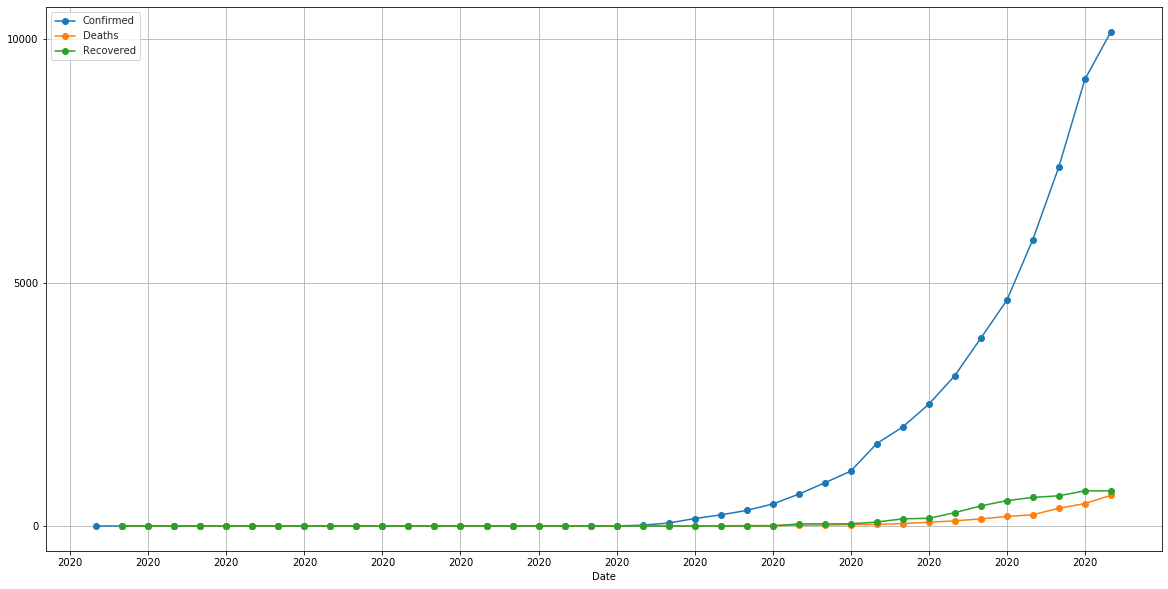

In [15]:
ax = plt.gca()

sns.set_style("whitegrid", {'grid.linestyle': ':'})
ax.yaxis.set_major_locator(ticker.MultipleLocator(Y_GRID_TICK))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

country_df.plot(x='Date', y=["Confirmed", "Deaths"], figsize=(20,10), ax=ax, marker='o')
country_df.plot(x='Date', y=["Recovered"], figsize=(20,10), ax=ax, marker='o')



$y = e^{ax}$

$\ln{y} = ax$

## ML analysis

In [16]:
from sklearn.linear_model import LinearRegression

In [38]:
# Set range of data to build model

# It might make sense to skip part of the initial points, when the exponential trend was still not evident
RANGE_START = 0
RANGE_END = None

In [39]:
len(x)

40

In [40]:
y = np.log(country_df['Confirmed'])
x = np.arange(len(y))

In [41]:
reg = LinearRegression()
reg.fit(x[RANGE_START:RANGE_END][:,np.newaxis], y[RANGE_START:RANGE_END])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Create dataframe with estimates

In [42]:
estimate_dates = pd.date_range(start='1/31/2020', end='03/15/2020')
estimate_cases = np.exp(reg.predict(np.arange(len(estimate_dates))[:, np.newaxis]))

In [43]:
df_estimates = pd.DataFrame({"Date": estimate_dates, "Predictions": estimate_cases})

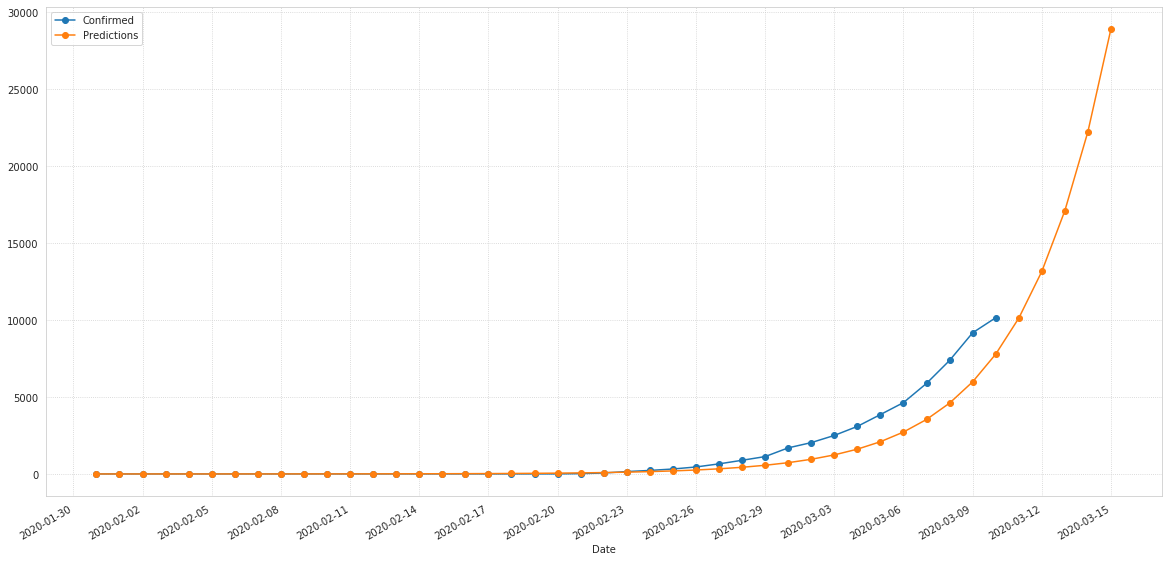

In [44]:
ax = plt.gca()

country_df.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='o')
df_estimates.plot(x='Date', y=["Predictions"], figsize=(20,10), ax=ax, marker='o')


ax.yaxis.set_major_locator(ticker.MultipleLocator(Y_GRID_TICK))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

# Use lines below in case you want to highlight a specific date/value

# ax.axhline(9172, 0, 1, ls=':', color='red')
# ax.axvline("2020-03-09", 0, 1, ls=':', color='red')

### Estimate people in IC

Assume that 10% of infected people require a bed in IC

In [35]:
country_df['Confirmed_IC'] = country_df['Confirmed']*0.1
df_estimates['Predictions_IC'] = df_estimates['Predictions']*0.1
df_estimates['IC caspacity (national)'] = ESTIMATED_IC_CAPACITY

### Plot results

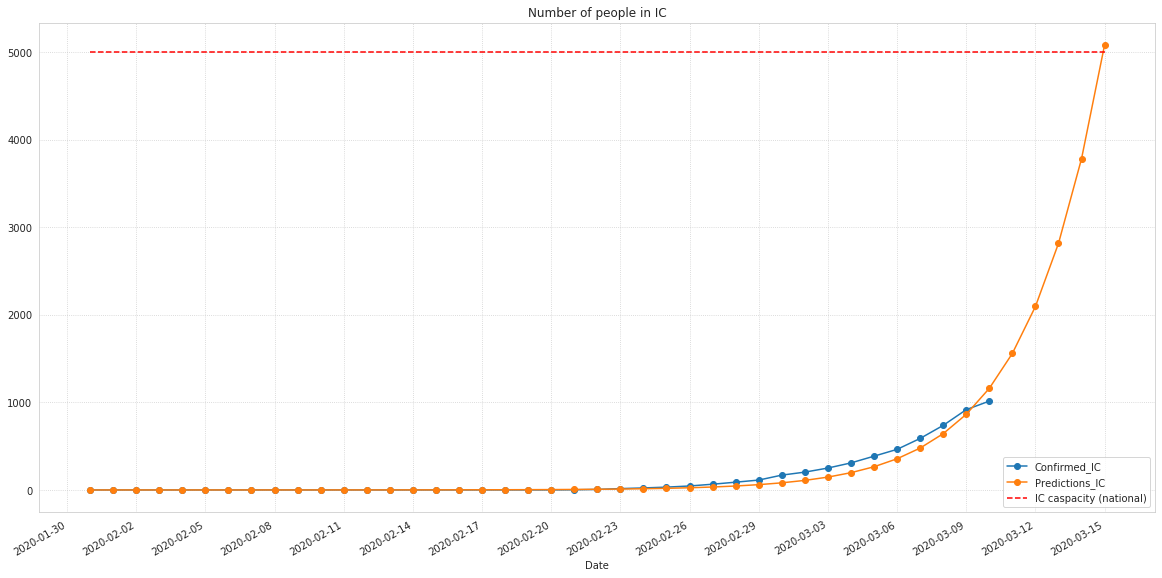

In [36]:
ax = plt.gca()

country_df.plot(x='Date', y=["Confirmed_IC"], figsize=(20,10), ax=ax, marker='o')
df_estimates.plot(x='Date', y=["Predictions_IC"], figsize=(20,10), ax=ax, marker='o')
df_estimates.plot(x='Date', y=['IC caspacity (national)'], ax=ax, color='red', ls='--')
plt.title("Number of people in IC");

sns.set_style("whitegrid", {'grid.linestyle': ':'})

# ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

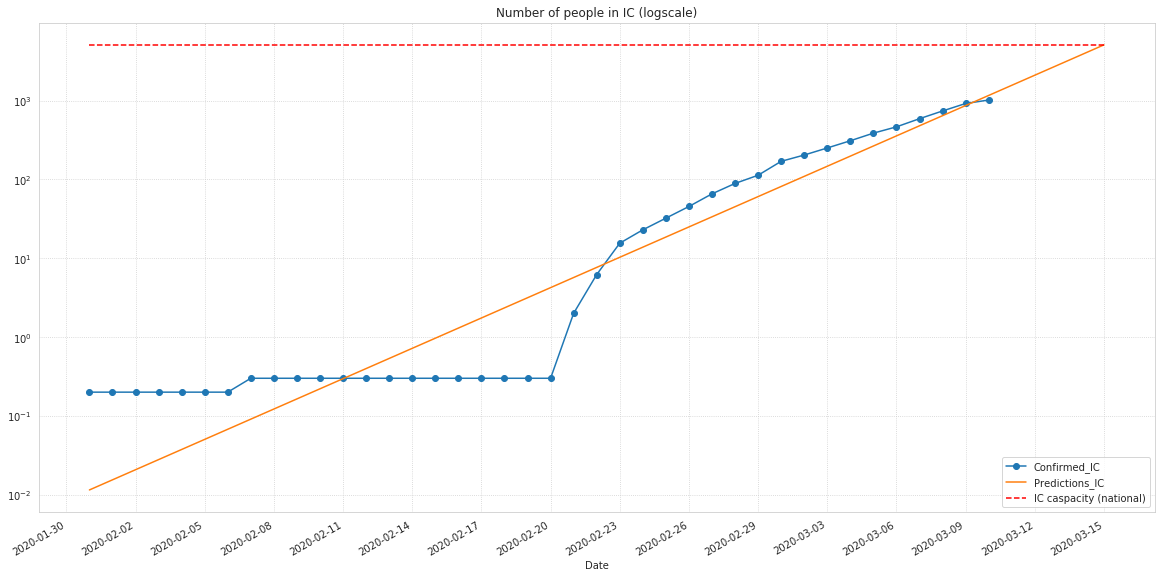

In [37]:
ax = plt.gca()

country_df.plot(x='Date', y=["Confirmed_IC"], figsize=(20,10), ax=ax, marker='o')
df_estimates.plot(x='Date', y=["Predictions_IC"], figsize=(20,10), ax=ax)
df_estimates.plot(x='Date', y=['IC caspacity (national)'], ax=ax, color='red', ls='--', logy=True)
plt.title("Number of people in IC (logscale)");

sns.set_style("whitegrid", {'grid.linestyle': ':'})

# ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))


## Countries comparison

In [45]:
def get_country_df(world_df, country_name):
    return world_df[world_df['Country/Region'] == country_name].sort_values(by='Date')


In [118]:
datetime(2020, 2, 14).date()

datetime.date(2020, 2, 14)

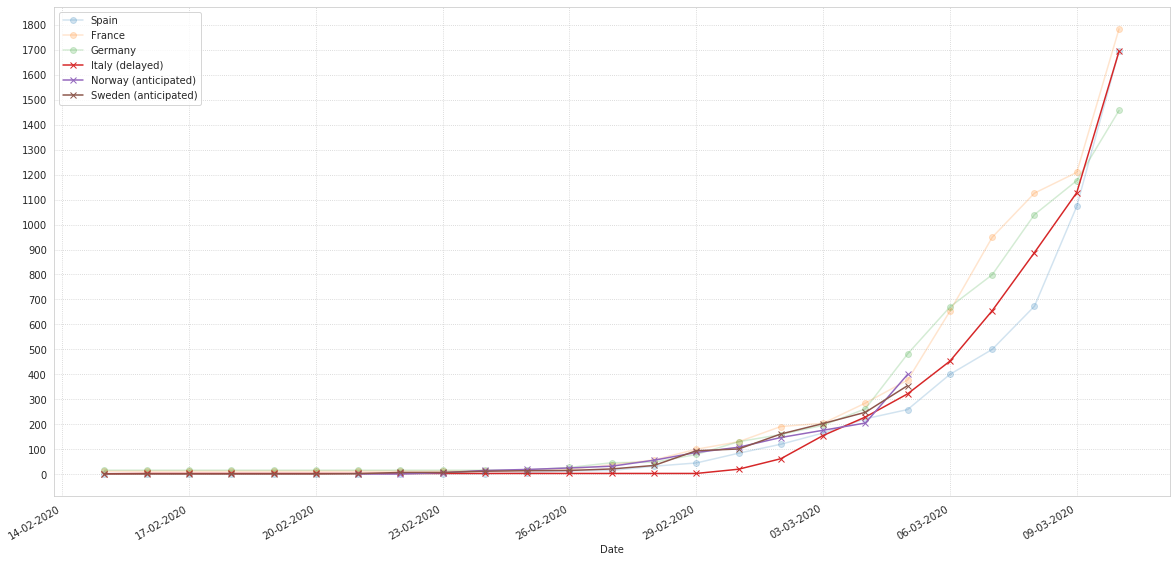

In [127]:
import matplotlib.dates as mdates

ax = plt.gca()

sns.set_style("whitegrid", {'grid.linestyle': ':'})
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))


countries_to_plot = [
#     "Italy",
    "Spain",
    "France",
    "Germany",
#     "Norway",
#     "Sweden",
]

for cc in countries_to_plot:
    c_df = get_country_df(world_df, cc)
    c_df = c_df[c_df['Date'] > datetime(2020, 2,14).date()]
    
    c_df.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='o', alpha=0.2)
    pass

italy_delayed = get_country_df(world_df, "Italy")
italy_delayed = italy_delayed.iloc[:-9,:]

# Adjust date
italy_delayed['Date'] = list(get_country_df(world_df, "Spain")['Date'][-31:])

norway_anticipated = get_country_df(world_df, "Norway")
norway_anticipated['Date'] = pd.date_range(end="03-05-2020", periods=len(norway_anticipated))

sweden_anticipated = get_country_df(world_df, "Sweden")
sweden_anticipated['Date'] = pd.date_range(end="03-05-2020", periods=len(sweden_anticipated))

# Plot adjusted countries
italy_delayed = italy_delayed[italy_delayed['Date'] > datetime(2020, 2,14).date()]
italy_delayed.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='x')

norway_anticipated = norway_anticipated[norway_anticipated['Date'] > "2020-02-14"]
sweden_anticipated = sweden_anticipated[sweden_anticipated['Date'] > "2020-02-14"]

norway_anticipated.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='x')
sweden_anticipated.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='x')

ax.legend(countries_to_plot + ['Italy (delayed)', 'Norway (anticipated)', 'Sweden (anticipated)'])
